# Final Project: Classifying Brain Tumors
Data from [Kaggle: brain_tumor_dataset](https://www.kaggle.com/datasets/balamosay/brain-tumor-dataset).

Classes
- 0 = glioma
- 1 = meningioma
- 2 = no tumor
- 3 = pituitary

## Import Packages

In [29]:
import sys
import math
import pathlib
import numpy as np
import tensorflow as tf
from os import makedirs, listdir, path
from shutil import copyfile, move
from random import seed, random
from matplotlib import pyplot
from keras.utils import to_categorical, img_to_array
from keras.models import Sequential, load_model
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import load_img
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, Dropout, Input
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import SGD

## Load in Data
- No Tumor: 200-250
- Others: 512x512

In [8]:
root = 'datasets/tumors'
current_dir = pathlib.Path.cwd().parent
combined = current_dir / root

In [41]:
batch_size = 64 
img_height = 224
img_width = 224
num_classes = 4
input_shape = (224, 224, 1)

In [37]:
# https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
# Images are grayscale, set color_mode to grayscale to convert RBG jpeg into 1 channel
train_ds = image_dataset_from_directory(
    combined / 'Training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale"
)

test_ds = image_dataset_from_directory(
    combined / 'Testing',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale"
)

val_ds = image_dataset_from_directory(
    combined / 'Validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale"
)

Found 2870 files belonging to 4 classes.
Found 386 files belonging to 4 classes.
Found 8 files belonging to 4 classes.


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Setup Utility Functions

In [21]:
# Plot diagnostic learning curves
def plot_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    pyplot.close() 
    
# Run test harness for a trained model 
def test_harness(model, epochs = 10):
    # fit model
    history = model.fit(train_ds, validation_data = test_ds, epochs = epochs, verbose = 1)
    # evaluate model
    _, acc = model.evaluate(test_ds, steps=len(test_ds), verbose=2)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    plot_diagnostics(history)

    return model

## One Block SGD VGG Model

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.4136 - loss: 5.1847 - val_accuracy: 0.4093 - val_loss: 3.1458
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.7611 - loss: 0.6358 - val_accuracy: 0.5181 - val_loss: 2.3934
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8343 - loss: 0.4733 - val_accuracy: 0.5622 - val_loss: 2.5075
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8703 - loss: 0.3861 - val_accuracy: 0.5777 - val_loss: 2.6535
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.8972 - loss: 0.3261 - val_accuracy: 0.5933 - val_loss: 2.7301
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9220 - loss: 0.2822 - val_accuracy: 0.6140 - val_loss: 2.7784
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.9383 - loss: 0.2470 - val_accuracy: 0.6347 - val_loss: 2.8096
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.9447 - loss: 0.2182 - val_accu

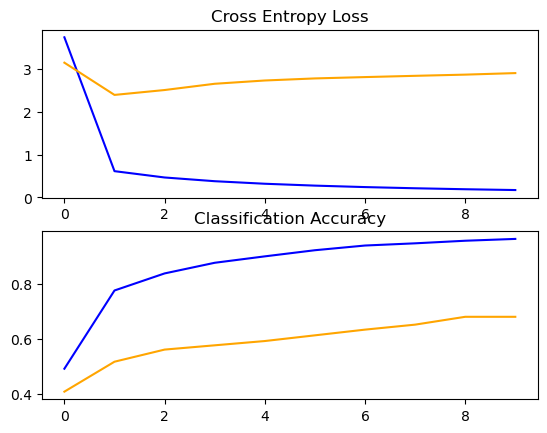

<Sequential name=sequential_10, built=True>

In [42]:
def one_block():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=input_shape),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D(),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

test_harness(one_block(), 10)

## One Block Adam VGG Model

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.4190 - loss: 17.3622 - val_accuracy: 0.3860 - val_loss: 17.1590
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.6780 - loss: 2.9275 - val_accuracy: 0.5674 - val_loss: 11.0920
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 288ms/step - accuracy: 0.8446 - loss: 0.8531 - val_accuracy: 0.5285 - val_loss: 9.1345
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.8142 - loss: 1.0731 - val_accuracy: 0.6373 - val_loss: 12.5861
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.8886 - loss: 0.6527 - val_accuracy: 0.5855 - val_loss: 10.9285
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.8768 - loss: 0.6804 - val_accuracy: 0.6062 - val_loss: 11.3066
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.9012 - loss: 0.4921 - val_accuracy: 0.7306 - val_loss: 12.5957
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.9546 - loss: 0.1807 - v

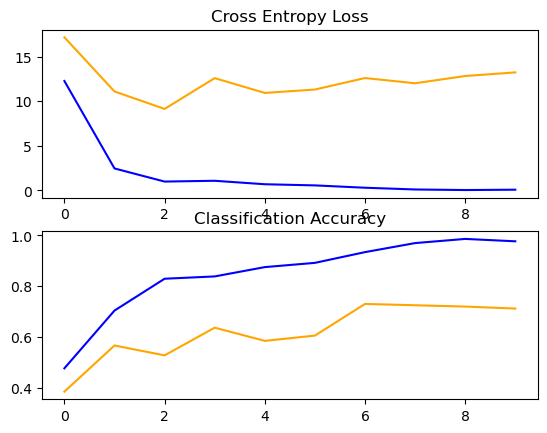

<Sequential name=sequential_6, built=True>

In [33]:
def one_adam():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D(),
        Flatten(),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

test_harness(one_adam(), 10)

## Three Block SGD VGG Model

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3823 - loss: 1.3923 - val_accuracy: 0.2850 - val_loss: 1.9245
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 995ms/step - accuracy: 0.6206 - loss: 0.8760 - val_accuracy: 0.3523 - val_loss: 1.9453
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6742 - loss: 0.7772 - val_accuracy: 0.4093 - val_loss: 1.9829
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 979ms/step - accuracy: 0.7105 - loss: 0.6987 - val_accuracy: 0.4301 - val_loss: 1.9539
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 980ms/step - accuracy: 0.7462 - loss: 0.6168 - val_accuracy: 0.4560 - val_loss: 2.0158
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 991ms/step - accuracy: 0.7775 - loss: 0.5545 - val_accuracy: 0.4560 - val_loss: 2.0550
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8071 - loss: 0.4978 - val_accuracy: 0.5052 - val_loss: 2.0589
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8360 - loss: 0.4318 - val_accuracy: 0.5389

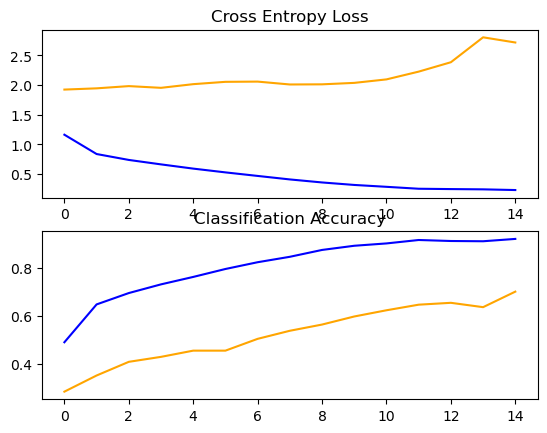

In [34]:
def three_sgd():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])
    
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

three_save = test_harness(three_sgd(), 15)

## Three Block ADAM VGG Model with Drop

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3909 - loss: 22.8646 - val_accuracy: 0.2176 - val_loss: 1.5553
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5607 - loss: 0.9913 - val_accuracy: 0.3990 - val_loss: 1.5079
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7011 - loss: 0.7315 - val_accuracy: 0.4585 - val_loss: 1.4154
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7978 - loss: 0.5305 - val_accuracy: 0.5674 - val_loss: 1.4680
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8615 - loss: 0.3649 - val_accuracy: 0.6295 - val_loss: 1.7540
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9060 - loss: 0.2574 - val_accuracy: 0.6710 - val_loss: 1.7429
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9101 - loss: 0.2372 - val_accuracy: 0.7176 - val_loss: 1.9389
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9357 - loss: 0.1703 - val_accuracy: 0.7254 - val_loss

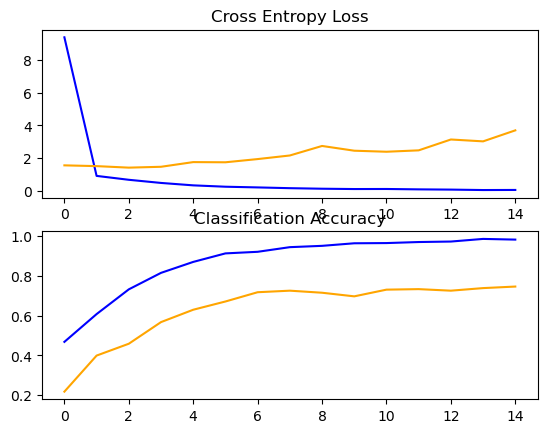

In [35]:
def three_adam_drop():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dropout(0.1),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

three_adam_drop_result = test_harness(three_adam_drop(), 15)

## Three Block VGG with Two Layers per block and Slight Dropout

In [ ]:
def three_two_layer():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=input_shape,
    	Conv2D(32, (3, 3), activation='relu', padding='same'),
    	Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
                  
    	Conv2D(64, (3, 3), activation='relu', padding='same'),
    	Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
                  
    	Conv2D(128, (3, 3), activation='relu', padding='same'),
    	Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
                  
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

three_two_layer_result = test_harness(three_two_layer(), 15)

## Four Block VGG Model with Adam optimizer 

In [ ]:
def four_block_adam():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_initializer='he_uniform'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

test_harness(four_block_adam(), 15)

## Make Prediction

In [111]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

In [115]:
malignant = load_image('../' + root + '/malignant/1373.jpg')
benign = load_image('../' + root + '/benign/1780.jpg')

In [118]:
model = load_model('three_block.keras')

pred_mal = model.predict(malignant)
pred_ben = model.predict(benign)

print(pred_mal[0])
print(pred_ben[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.83937037]
[0.04634498]
